In [9]:
## first softmax version
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
# Cell 1: Import the module
from gp_softmax_torch_4 import *
## first softmax version
%load_ext autoreload
%autoreload 2
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Generate synthetic data
N, D, T, K, P = 100, 5, 50, 3, 5
Y_np, G_np, prevalence_np, event_times_np = generate_synthetic_data(
    N=N, D=D, T=T, K=K, P=P
)

# Initialize model
model = AladynSurvivalModel(
    N=N, D=D, T=T, K=K, P=P,
    G=G_np,
    Y=Y_np,
    prevalence=prevalence_np
)

# Train model
losses = model.fit(event_times_np, num_epochs=1000, learning_rate=1e-3)

# Plot losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

NameError: name 'AladynSurvivalModel' is not defined

In [21]:
import torch
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import expit
import matplotlib.pyplot as plt

# 1. Data Generation Function
def generate_synthetic_data(N=100, D=5, T=50, K=3, P=5, return_true_params=False):
    """Generate synthetic survival data for testing the model."""
    np.random.seed(123)

    # Genetic covariates G (N x P)
    G = np.random.randn(N, P)

    # Prevalence of diseases (D)
    prevalence = np.random.uniform(0.01, 0.05, D)

    # Length scales and amplitudes for GP kernels
    length_scales = np.random.uniform(T / 3, T / 2, K)
    amplitudes = np.random.uniform(0.8, 1.2, K)

    # Generate time differences for covariance matrices
    time_points = np.arange(T)
    time_diff = time_points[:, None] - time_points[None, :]

    # Simulate mu_d (average disease prevalence trajectories)
    mu_d = np.zeros((D, T))
    for d in range(D):
        base_trend = np.log(prevalence[d]) * np.ones(T)
        mu_d[d, :] = base_trend

    # Simulate lambda (individual-topic trajectories)
    Gamma_k = np.random.randn(P, K)
    lambda_ik = np.zeros((N, K, T))
    for k in range(K):
        cov_matrix = amplitudes[k] ** 2 * np.exp(-0.5 * (time_diff ** 2) / length_scales[k] ** 2)
        for i in range(N):
            mean_lambda = G[i] @ Gamma_k[:, k]
            lambda_ik[i, k, :] = multivariate_normal.rvs(mean=mean_lambda * np.ones(T), cov=cov_matrix)

    # Compute theta
    exp_lambda = np.exp(lambda_ik)
    theta = exp_lambda / np.sum(exp_lambda, axis=1, keepdims=True)

    # Simulate phi (topic-disease trajectories)
    phi_kd = np.zeros((K, D, T))
    for k in range(K):
        cov_matrix = amplitudes[k] ** 2 * np.exp(-0.5 * (time_diff ** 2) / length_scales[k] ** 2)
        for d in range(D):
            mean_phi = np.log(prevalence[d]) * np.ones(T)
            phi_kd[k, d, :] = multivariate_normal.rvs(mean=mean_phi, cov=cov_matrix)

    # Compute eta and pi
    eta = expit(phi_kd)
    pi = np.einsum('nkt,kdt->ndt', theta, eta)

    # Generate survival data Y
    Y = np.zeros((N, D, T), dtype=int)
    event_times = np.full((N, D), T)
    for n in range(N):
        for d in range(D):
            for t in range(T):
                if Y[n, d, :t].sum() == 0:
                    if np.random.rand() < pi[n, d, t]:
                        Y[n, d, t] = 1
                        event_times[n, d] = t
                        break

    if return_true_params:
        return {
            'Y': Y,
            'G': G,
            'prevalence': prevalence,
            'length_scales': length_scales,
            'amplitudes': amplitudes,
            'event_times': event_times,
            'theta': theta,
            'phi': phi_kd,
            'lambda': lambda_ik,
            'gamma': Gamma_k,
            'pi': pi
        }
    else:
        return Y, G, prevalence, event_times

# 2. Model Class
class AladynoulliModel(torch.nn.Module):
    def __init__(self, N, D, T, K, P, G, Y, prevalence, length_scale_prior, device='cpu'):
        super().__init__()
        # Dimensions
        self.N = N
        self.D = D
        self.T = T
        self.K = K
        self.P = P
        self.device = device
        
        # Data
        self.G = torch.tensor(G, dtype=torch.float32, device=device)
        self.Y = torch.tensor(Y, dtype=torch.float32, device=device)
        self.prevalence = torch.tensor(prevalence, dtype=torch.float32, device=device)
        
        # GP parameters
        self.jitter = 1e-6
        self.time_points = torch.linspace(0, 1, T, device=device)
        self.length_scale_alpha, self.length_scale_beta = length_scale_prior
        
        # Initialize model parameters
        self.B = torch.nn.Parameter(
            torch.randn(P, K, device=device) / np.sqrt(P)
        )
        self.U = torch.nn.Parameter(
            torch.randn(D, K, device=device) / np.sqrt(D)
        )
        self.log_length_scale = torch.nn.Parameter(
            torch.zeros(K, device=device)
        )
        self.log_variance = torch.nn.Parameter(
            torch.zeros(K, device=device)
        )
        
        # Set up GP kernels
        self.setup_gp_kernels()
        
    def setup_gp_kernels(self):
        """Setup GP kernels for each signature"""
        t = self.time_points.view(-1, 1)
        self.time_diffs = t - t.T
        self.K_t = torch.zeros(self.K, self.T, self.T, device=self.device)
        self.update_kernels()
    
    def update_kernels(self):
        """Update GP kernel matrices"""
        for k in range(self.K):
            length_scale = torch.exp(self.log_length_scale[k])
            variance = torch.exp(self.log_variance[k])
            scaled_diffs = self.time_diffs / length_scale
            self.K_t[k] = variance * torch.exp(-0.5 * scaled_diffs**2)
            self.K_t[k] += self.jitter * torch.eye(self.T, device=self.device)
    
      def forward(self):
        """Compute model predictions"""
        self.update_kernels()
        
        # Compute genetic effects (N × K)
        genetic_effects = self.G @ self.B
        
        # Sample GP functions (K × T) with reparameterization trick
        f = []
        for k in range(self.K):
            L = torch.linalg.cholesky(self.K_t[k])
            # Create new random samples each time
            eps = torch.randn(self.T, device=self.device, requires_grad=True)
            f_k = L @ eps
            f.append(f_k)
        f = torch.stack(f)  # (K × T)
        
        # Compute individual effects (N × K × T)
        individual_effects = torch.einsum('nk,kt->nkt', genetic_effects, f)
        
        # Combine with disease effects (D × K)
        logits = torch.einsum('nkt,dk->ndt', individual_effects, self.U)
        
        # Convert to probabilities
        probs = torch.sigmoid(logits)
        
        return probs

    def compute_loss(self):
        """Compute negative log likelihood and priors"""
        probs = self.forward()
        
        # Binary cross-entropy loss
        likelihood = torch.sum(
            self.Y * torch.log(probs + 1e-10) +
            (1 - self.Y) * torch.log(1 - probs + 1e-10)
        )
        
        # Prior terms
        length_scale_prior = torch.sum(
            -self.length_scale_alpha * self.log_length_scale +
            self.length_scale_beta * torch.exp(-self.log_length_scale)
        )
        
        # L2 regularization
        reg = -0.5 * (torch.sum(self.B**2) + torch.sum(self.U**2))
        
        return -(likelihood + length_scale_prior + reg)

    def train_model(sim_data, n_epochs=1000, lr=0.01, device='cpu'):
        """Train the AladynoulliModel with simulated data"""
        N, P = sim_data['G'].shape
        N, D, T = sim_data['Y'].shape
        K = sim_data['lambda'].shape[1]
        
        print("Initializing model...")
        model = AladynoulliModel(
            N=N, D=D, T=T, K=K, P=P,
            G=sim_data['G'],
            Y=sim_data['Y'],
            prevalence=sim_data['prevalence'],
            length_scale_prior=(2.0, 5.0),
            device=device
        )
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        losses = []
        print("Training model...")
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            loss = model.compute_loss()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        
        return model, losses

    # 4. Evaluation Function
    def evaluate_results(model, sim_data):
        """Compare learned parameters with true parameters"""
        with torch.no_grad():
            probs = model.forward().cpu().numpy()
            B_learned = model.B.cpu().numpy()
            gamma_true = sim_data['gamma']
            
            B_corr = np.corrcoef(B_learned.flatten(), gamma_true.flatten())[0,1]
            prob_corr = np.corrcoef(probs.flatten(), sim_data['pi'].flatten())[0,1]
            
            print("\nResults:")
            print(f"Genetic effects correlation: {B_corr:.3f}")
            print(f"Probability prediction correlation: {prob_corr:.3f}")
            
            return {
                'B_corr': B_corr,
                'prob_corr': prob_corr,
                'probs': probs,
                'B_learned': B_learned
            }

    # 5. Visualization Function
    def plot_results(losses, results, sim_data):
        """Plot training progress and comparisons"""
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.plot(losses)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')
        
        plt.subplot(132)
        plt.scatter(sim_data['pi'].flatten(), results['probs'].flatten(), alpha=0.1)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.title('True vs Predicted Probabilities')
        plt.xlabel('True')
        plt.ylabel('Predicted')
        
        plt.subplot(133)
        plt.scatter(sim_data['gamma'].flatten(), results['B_learned'].flatten(), alpha=0.1)
        plt.plot([-3, 3], [-3, 3], 'r--')
        plt.title('True vs Learned Genetic Effects')
        plt.xlabel('True')
        plt.ylabel('Learned')
        
        plt.tight_layout()
        plt.show()

    # Example usage:


In [22]:
# 1. Simulate data
sim_data = generate_synthetic_data(
    N=1000, D=10, T=50, K=3, P=50, 
    return_true_params=True
)

# 2. Train model (specify device='cpu')
model, losses = train_model(sim_data, device='cpu')

# 3. Evaluate results
results = evaluate_results(model, sim_data)

# 4. Plot results
plot_results(losses, results, sim_data)

Initializing model...
Training model...
Epoch 0, Loss: 372810.5312


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [18]:
# 1. Simulate data
sim_data = generate_synthetic_data(
    N=1000, D=10, T=50, K=3, P=50, 
    return_true_params=True
)

# 2. Train model (specify device='cpu')
model, losses = train_model(sim_data, device='cpu')

# 3. Evaluate results
results = evaluate_results(model, sim_data)

# 4. Plot results
plot_results(losses, results, sim_data)

Initializing model...


AttributeError: 'AladynoulliModel' object has no attribute 'parameters'

In [12]:


# Standardize genetic covariates
scaler = StandardScaler()
G = scaler.fit_transform(G)

# Convert event times to tensor
event_times = torch.tensor(event_times, dtype=torch.long)


In [13]:

# Initialize model
print("Initializing model...")
model = AladynoulliModel(
    N=N,
    D=D,
    T=T,
    K=K,
    P=P,
    G=G,
    Y=Y,
    prevalence=prevalence,
    length_scale_prior=(2.0, 5.0)  # Shape and scale for Gamma prior
)


Initializing model...


AttributeError: 'AladynoulliModel' object has no attribute 'initialize_parameters'

In [ ]:

# Train model
print("Training model...")
history = model.fit(
    event_times=event_times,
    num_epochs=500,
    learning_rate=0.01,
    patience=20,
    min_delta=1e-4
)

# Plot training history
print("Plotting training history...")
plot_training_history(history)

# Evaluate model
print("Evaluating model...")
pi, theta, phi_prob = evaluate_model(model, Y, event_times)

# Example of making predictions for new individuals
print("Making predictions for new individuals...")
G_new = np.random.randn(5, P)  # 5 new individuals
G_new = scaler.transform(G_new)

pred_pi, pred_theta = model.predict(
    G_new=torch.tensor(G_new, dtype=torch.float32)
)

print("Prediction shapes:")
print(f"pi: {pred_pi.shape}")
print(f"theta: {pred_theta.shape}")



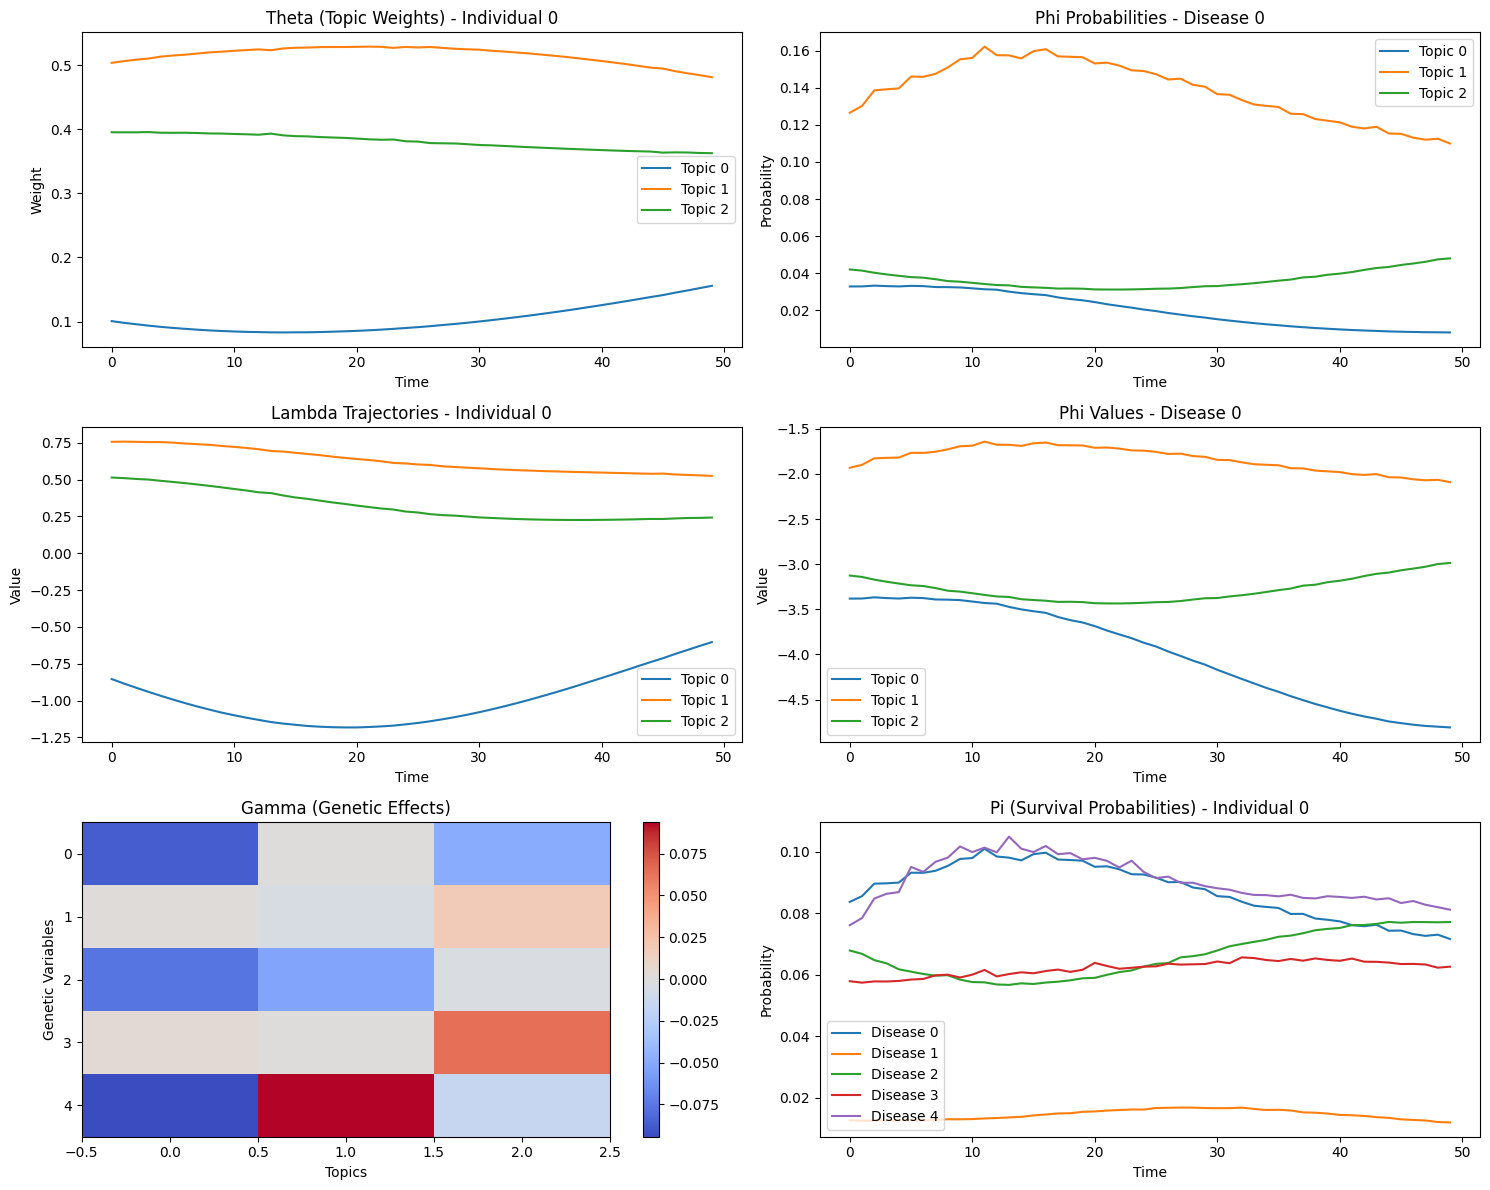

In [11]:
# Get model outputs
pi, theta, phi_prob = model.forward()

# Create visualization
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# 1. Plot theta (topic weights) for first few individuals
theta_np = theta.detach().numpy()
for k in range(K):
    axes[0, 0].plot(theta_np[0, k, :], label=f'Topic {k}')
axes[0, 0].set_title('Theta (Topic Weights) - Individual 0')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Plot phi probabilities for first few diseases
phi_prob_np = phi_prob.detach().numpy()
for k in range(K):
    axes[0, 1].plot(phi_prob_np[k, 0, :], label=f'Topic {k}')
axes[0, 1].set_title('Phi Probabilities - Disease 0')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()

# 3. Plot lambda trajectories
lambda_np = model.lambda_.detach().numpy()
for k in range(K):
    axes[1, 0].plot(lambda_np[0, k, :], label=f'Topic {k}')
axes[1, 0].set_title('Lambda Trajectories - Individual 0')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()

# 4. Plot raw phi values
phi_np = model.phi.detach().numpy()
for k in range(K):
    axes[1, 1].plot(phi_np[k, 0, :], label=f'Topic {k}')
axes[1, 1].set_title('Phi Values - Disease 0')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()

# 5. Plot gamma (genetic effects) as heatmap
gamma_np = model.gamma.detach().numpy()
im = axes[2, 0].imshow(gamma_np, aspect='auto', cmap='coolwarm')
axes[2, 0].set_title('Gamma (Genetic Effects)')
axes[2, 0].set_xlabel('Topics')
axes[2, 0].set_ylabel('Genetic Variables')
plt.colorbar(im, ax=axes[2, 0])

# 6. Plot final survival probabilities for first individual
pi_np = pi.detach().numpy()
for d in range(D):
    axes[2, 1].plot(pi_np[0, d, :], label=f'Disease {d}')
axes[2, 1].set_title('Pi (Survival Probabilities) - Individual 0')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('Probability')
axes[2, 1].legend()

plt.tight_layout()
plt.show()

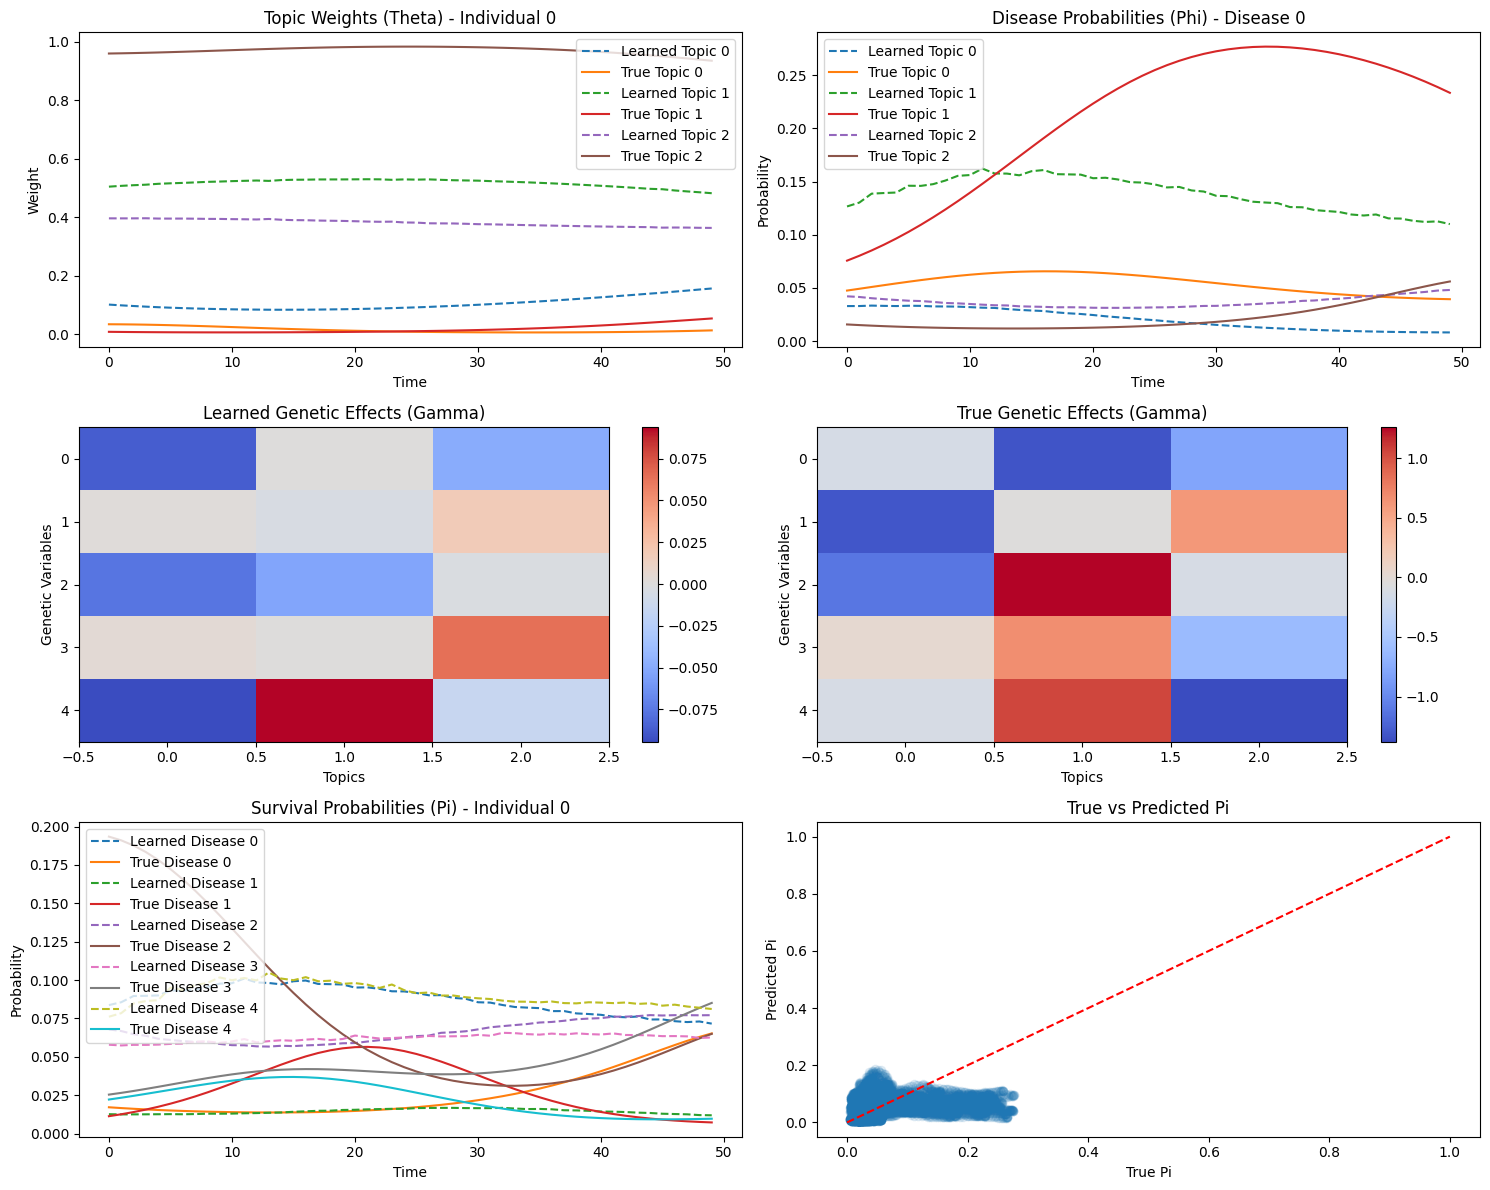


Numerical Metrics:
R² score for Pi: -0.108
MSE for Pi: 0.002236
R² score for Theta: -0.378
R² score for Gamma: -0.043


In [12]:
# Get model predictions and true parameters
pi, theta, phi_prob = model.forward()

# Get true parameters from data generation
true_data = generate_synthetic_data(N=N, D=D, T=T, K=K, P=P, return_true_params=True)

# Create evaluation plots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# 1. Topic Weights (Theta)
theta_np = theta.detach().numpy()
for k in range(K):
    axes[0, 0].plot(theta_np[0, k, :], '--', label=f'Learned Topic {k}')
    axes[0, 0].plot(true_data['theta'][0, k, :], '-', label=f'True Topic {k}')
axes[0, 0].set_title('Topic Weights (Theta) - Individual 0')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Disease Probabilities (Phi)
phi_prob_np = phi_prob.detach().numpy()
for k in range(K):
    axes[0, 1].plot(phi_prob_np[k, 0, :], '--', label=f'Learned Topic {k}')
    axes[0, 1].plot(expit(true_data['phi'][k, 0, :]), '-', label=f'True Topic {k}')
axes[0, 1].set_title('Disease Probabilities (Phi) - Disease 0')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()

# 3. Genetic Effects (Gamma)
gamma_np = model.gamma.detach().numpy()
im = axes[1, 0].imshow(gamma_np, aspect='auto', cmap='coolwarm')
plt.colorbar(im, ax=axes[1, 0])
axes[1, 0].set_title('Learned Genetic Effects (Gamma)')
axes[1, 0].set_xlabel('Topics')
axes[1, 0].set_ylabel('Genetic Variables')

im = axes[1, 1].imshow(true_data['gamma'], aspect='auto', cmap='coolwarm')
plt.colorbar(im, ax=axes[1, 1])
axes[1, 1].set_title('True Genetic Effects (Gamma)')
axes[1, 1].set_xlabel('Topics')
axes[1, 1].set_ylabel('Genetic Variables')

# 4. Final Survival Probabilities (Pi)
pi_np = pi.detach().numpy()
for d in range(D):
    axes[2, 0].plot(pi_np[0, d, :], '--', label=f'Learned Disease {d}')
    axes[2, 0].plot(true_data['pi'][0, d, :], '-', label=f'True Disease {d}')
axes[2, 0].set_title('Survival Probabilities (Pi) - Individual 0')
axes[2, 0].set_xlabel('Time')
axes[2, 0].set_ylabel('Probability')
axes[2, 0].legend()

# 5. True vs Predicted Pi
axes[2, 1].scatter(true_data['pi'].flatten(), pi_np.flatten(), alpha=0.1)
axes[2, 1].plot([0, 1], [0, 1], 'r--')
axes[2, 1].set_title('True vs Predicted Pi')
axes[2, 1].set_xlabel('True Pi')
axes[2, 1].set_ylabel('Predicted Pi')

plt.tight_layout()
plt.show()

# Print numerical metrics
from sklearn.metrics import r2_score, mean_squared_error
print("\nNumerical Metrics:")
print(f"R² score for Pi: {r2_score(true_data['pi'].flatten(), pi_np.flatten()):.3f}")
print(f"MSE for Pi: {mean_squared_error(true_data['pi'].flatten(), pi_np.flatten()):.6f}")
print(f"R² score for Theta: {r2_score(true_data['theta'].flatten(), theta_np.flatten()):.3f}")
print(f"R² score for Gamma: {r2_score(true_data['gamma'].flatten(), gamma_np.flatten()):.3f}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 0, Loss: 6331.2036
Epoch 10, Loss: 1895.3119
Epoch 20, Loss: 1448.5571
Epoch 30, Loss: 1259.9650
Epoch 40, Loss: 1173.2258
Epoch 50, Loss: 1111.0790
Epoch 60, Loss: 1066.3730
Epoch 70, Loss: 1022.7789
Epoch 80, Loss: 981.3407
Epoch 90, Loss: 940.3265


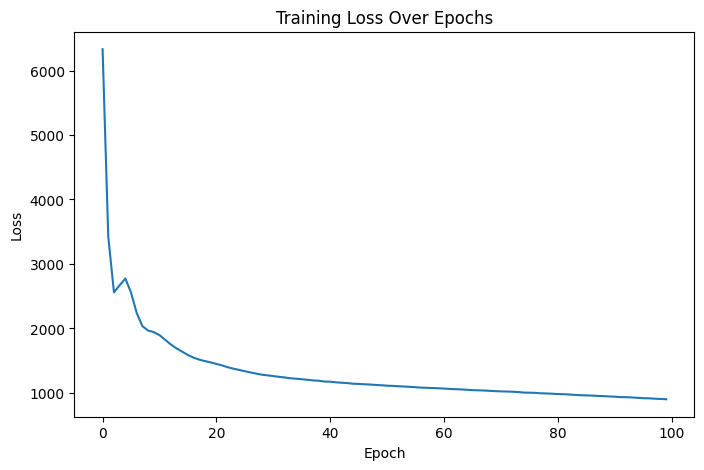

In [27]:
# Example usage:
## first softmax version
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
# Cell 1: Import the module
from gp_softmax_torch_3 import *
## first softmax version
%load_ext autoreload
%autoreload 2
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate synthetic data
N = 100  # Number of individuals
D = 5    # Number of diseases
T = 50   # Number of time points
K = 3    # Number of topics
P = 5    # Number of genetic covariates

Y, G, prevalence, length_scales, amplitudes, event_times = generate_synthetic_data(
    N=N, D=D, T=T, K=K, P=P, return_true_params=False
)

# Initialize the model
model = AladynSurvivalModel(N, D, T, K, P, G, Y, length_scales, amplitudes, prevalence)

# Fit the model
num_epochs = 100
learning_rate = 1e-3
losses = model.fit(event_times, num_epochs=num_epochs, learning_rate=learning_rate)

# Plot the training loss
plt.figure(figsize=(8, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

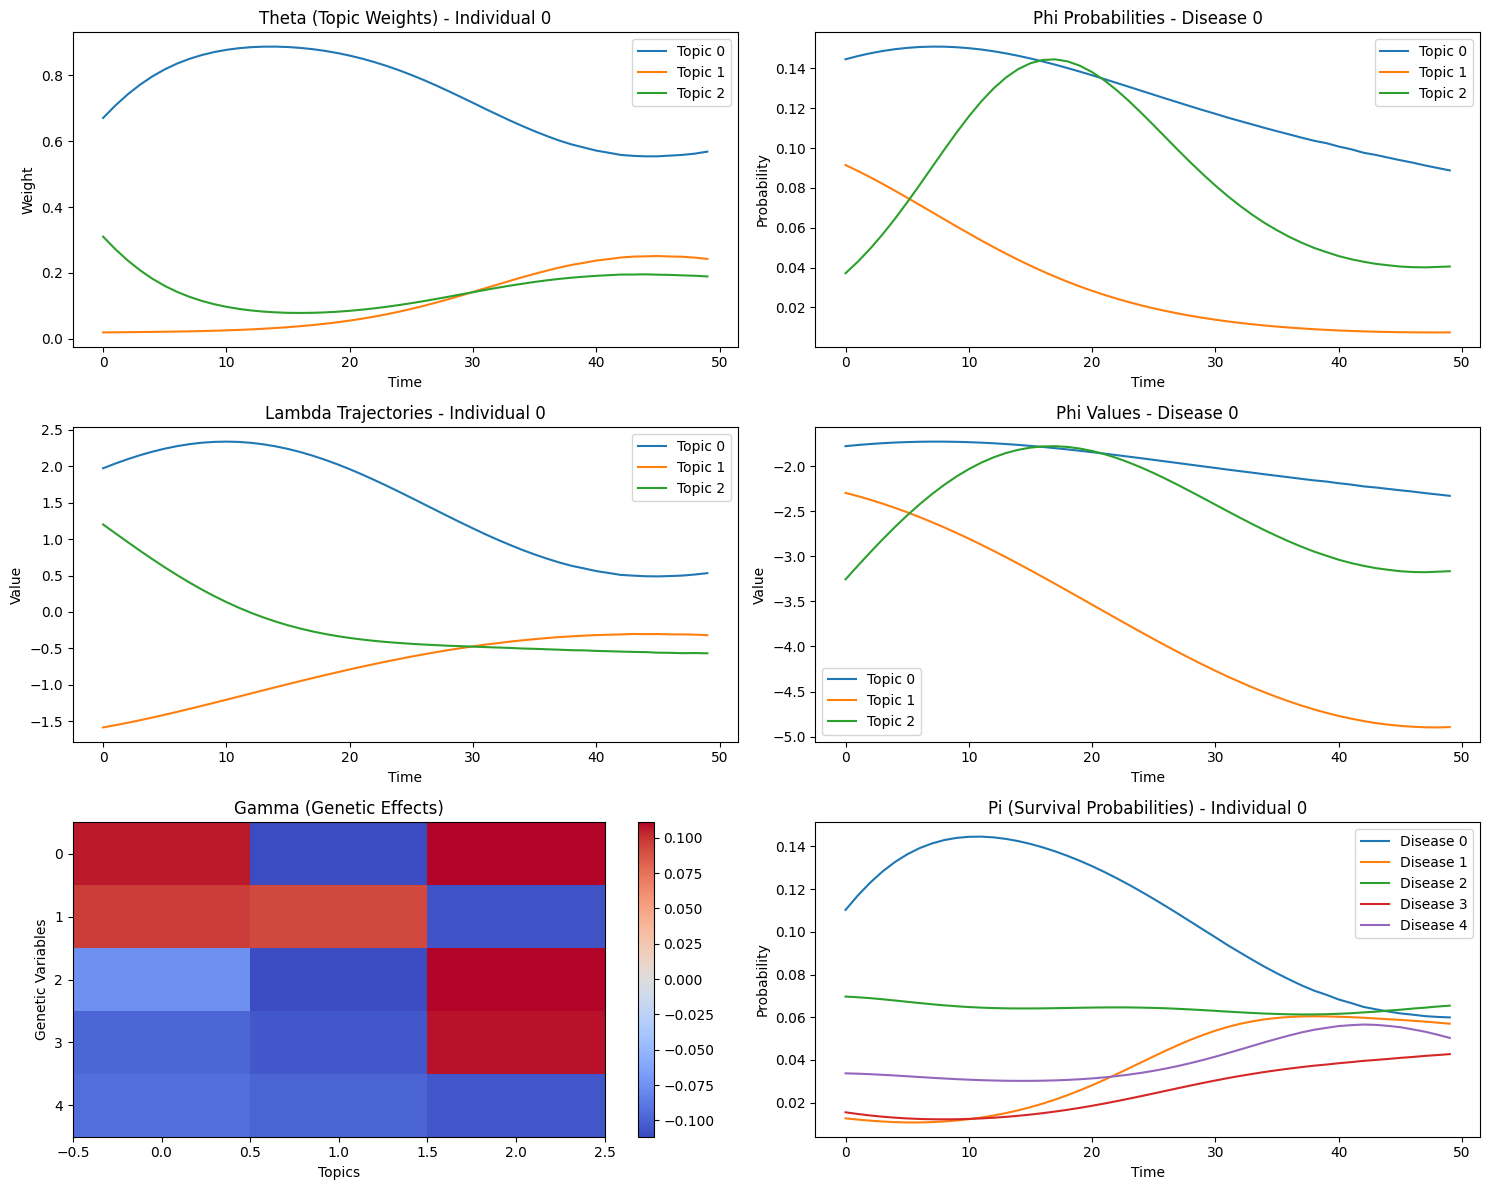

In [28]:
# Get model outputs
pi, theta, phi_prob = model.forward()

# Create visualization
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# 1. Plot theta (topic weights) for first few individuals
theta_np = theta.detach().numpy()
for k in range(K):
    axes[0, 0].plot(theta_np[0, k, :], label=f'Topic {k}')
axes[0, 0].set_title('Theta (Topic Weights) - Individual 0')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Plot phi probabilities for first few diseases
phi_prob_np = phi_prob.detach().numpy()
for k in range(K):
    axes[0, 1].plot(phi_prob_np[k, 0, :], label=f'Topic {k}')
axes[0, 1].set_title('Phi Probabilities - Disease 0')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()

# 3. Plot lambda trajectories
lambda_np = model.lambda_.detach().numpy()
for k in range(K):
    axes[1, 0].plot(lambda_np[0, k, :], label=f'Topic {k}')
axes[1, 0].set_title('Lambda Trajectories - Individual 0')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()

# 4. Plot raw phi values
phi_np = model.phi.detach().numpy()
for k in range(K):
    axes[1, 1].plot(phi_np[k, 0, :], label=f'Topic {k}')
axes[1, 1].set_title('Phi Values - Disease 0')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()

# 5. Plot gamma (genetic effects) as heatmap
gamma_np = model.gamma.detach().numpy()
im = axes[2, 0].imshow(gamma_np, aspect='auto', cmap='coolwarm')
axes[2, 0].set_title('Gamma (Genetic Effects)')
axes[2, 0].set_xlabel('Topics')
axes[2, 0].set_ylabel('Genetic Variables')
plt.colorbar(im, ax=axes[2, 0])

# 6. Plot final survival probabilities for first individual
pi_np = pi.detach().numpy()
for d in range(D):
    axes[2, 1].plot(pi_np[0, d, :], label=f'Disease {d}')
axes[2, 1].set_title('Pi (Survival Probabilities) - Individual 0')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('Probability')
axes[2, 1].legend()

plt.tight_layout()
plt.show()

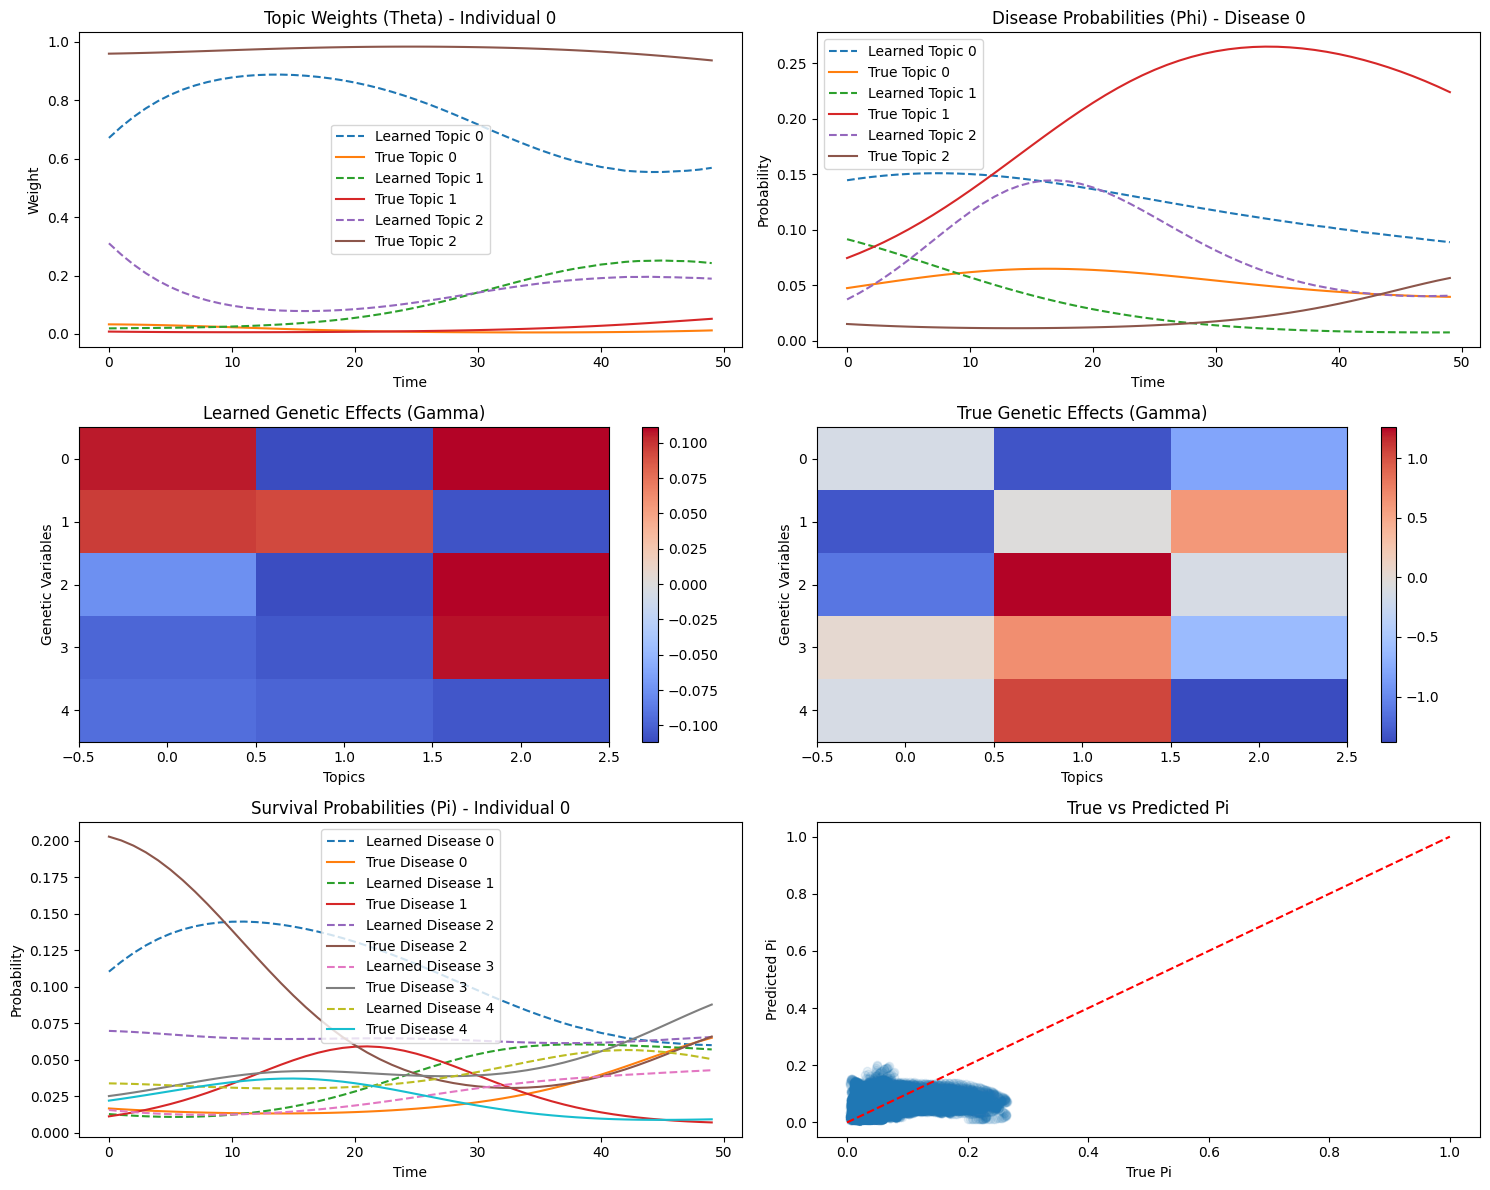


Numerical Metrics:
R² score for Pi: -0.037
MSE for Pi: 0.001967
R² score for Theta: -0.404
R² score for Gamma: -0.146


In [29]:
# Get model predictions and true parameters
pi, theta, phi_prob = model.forward()

# Get true parameters from data generation
true_data = generate_synthetic_data(N=N, D=D, T=T, K=K, P=P, return_true_params=True)

# Create evaluation plots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# 1. Topic Weights (Theta)
theta_np = theta.detach().numpy()
for k in range(K):
    axes[0, 0].plot(theta_np[0, k, :], '--', label=f'Learned Topic {k}')
    axes[0, 0].plot(true_data['theta'][0, k, :], '-', label=f'True Topic {k}')
axes[0, 0].set_title('Topic Weights (Theta) - Individual 0')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Disease Probabilities (Phi)
phi_prob_np = phi_prob.detach().numpy()
for k in range(K):
    axes[0, 1].plot(phi_prob_np[k, 0, :], '--', label=f'Learned Topic {k}')
    axes[0, 1].plot(expit(true_data['phi'][k, 0, :]), '-', label=f'True Topic {k}')
axes[0, 1].set_title('Disease Probabilities (Phi) - Disease 0')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()

# 3. Genetic Effects (Gamma)
gamma_np = model.gamma.detach().numpy()
im = axes[1, 0].imshow(gamma_np, aspect='auto', cmap='coolwarm')
plt.colorbar(im, ax=axes[1, 0])
axes[1, 0].set_title('Learned Genetic Effects (Gamma)')
axes[1, 0].set_xlabel('Topics')
axes[1, 0].set_ylabel('Genetic Variables')

im = axes[1, 1].imshow(true_data['gamma'], aspect='auto', cmap='coolwarm')
plt.colorbar(im, ax=axes[1, 1])
axes[1, 1].set_title('True Genetic Effects (Gamma)')
axes[1, 1].set_xlabel('Topics')
axes[1, 1].set_ylabel('Genetic Variables')

# 4. Final Survival Probabilities (Pi)
pi_np = pi.detach().numpy()
for d in range(D):
    axes[2, 0].plot(pi_np[0, d, :], '--', label=f'Learned Disease {d}')
    axes[2, 0].plot(true_data['pi'][0, d, :], '-', label=f'True Disease {d}')
axes[2, 0].set_title('Survival Probabilities (Pi) - Individual 0')
axes[2, 0].set_xlabel('Time')
axes[2, 0].set_ylabel('Probability')
axes[2, 0].legend()

# 5. True vs Predicted Pi
axes[2, 1].scatter(true_data['pi'].flatten(), pi_np.flatten(), alpha=0.1)
axes[2, 1].plot([0, 1], [0, 1], 'r--')
axes[2, 1].set_title('True vs Predicted Pi')
axes[2, 1].set_xlabel('True Pi')
axes[2, 1].set_ylabel('Predicted Pi')

plt.tight_layout()
plt.show()

# Print numerical metrics
from sklearn.metrics import r2_score, mean_squared_error
print("\nNumerical Metrics:")
print(f"R² score for Pi: {r2_score(true_data['pi'].flatten(), pi_np.flatten()):.3f}")
print(f"MSE for Pi: {mean_squared_error(true_data['pi'].flatten(), pi_np.flatten()):.6f}")
print(f"R² score for Theta: {r2_score(true_data['theta'].flatten(), theta_np.flatten()):.3f}")
print(f"R² score for Gamma: {r2_score(true_data['gamma'].flatten(), gamma_np.flatten()):.3f}")